# Import Library

In [1]:
import os
import random
import librosa
import librosa.display
import librosa.util
import cv2

import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

from keras.preprocessing import image
from keras.initializers import glorot_uniform, glorot_normal
from skimage.metrics import structural_similarity as ssim
import soundfile as sf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("tensorflow: ",tf.__version__)
print("librosa: ",librosa.__version__)
print("numpy: ", np.__version__)

2024-09-02 14:18:15.160748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 14:18:15.160849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 14:18:15.292783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow:  2.15.0
librosa:  0.10.2.post1
numpy:  1.26.4


# Preprocess Data

In [3]:
arterial = '/dataset-skripsi/logmel_spectrogram/binary/arterial/'
nonarterial = '/dataset-skripsi/logmel_spectrogram/binary/nonarterial'

binary = '/dataset-skripsi/logmel_spectrogram/binary/'

Preprocess spectrogram with:

* resize (128x128) ,
* convert into grayscale (1),
* normalization [-1,1] 

In [4]:
def preprocess_spectrogram(image_path, label):
    try:
        image_path = tf.strings.as_string(image_path)

        # Load the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        
        if tf.shape(img).shape[0] != 3:  # Ensure the image has 3 dimensions (height, width, channels)
            print(f"Error loading image: {image_path}")
            return None, label
        
        # Resize to 128x128
        img = tf.image.resize(img, [128, 128])
        img = tf.image.rgb_to_grayscale(img)
        img = tf.cast(img, tf.float32) / 127.5 - 1
        
        return img, label
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None, label
    except Exception as e:
        print(f"Unexpected error processing image {image_path}: {str(e)}")
        return None, label

def create_single_class_dataset(class_dir, batch_size=16):
    if not os.path.isdir(class_dir):
        raise ValueError(f"Directory {class_dir} does not exist.")

    file_paths = []
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(class_dir, filename)
            if os.path.exists(file_path):
                file_paths.append(file_path)
            else:
                print(f"File not found: {file_path}")
    
    labels = [0] * len(file_paths)

    # Create tf.data.Dataset
    file_paths = tf.constant(file_paths)  # Ensure file_paths is a tensor of strings
    labels = tf.constant(labels, dtype=tf.int32)  # Ensure labels are integers
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y: x is not None)  # Remove failed images
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Example usage
class_dir = '/dataset-skripsi/dataset_ver6/spectrogram2/binary/arterial'  # Adjusted to focus on a single class folder
train_dataset = create_single_class_dataset(class_dir)

# Print some information about the dataset
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

# If the loop doesn't execute, print an error message
if not list(train_dataset.take(1)):
    print("No data was processed. Please check the dataset and preprocessing steps.")


Batch shape: (16, 128, 128, 1)
Labels shape: (16,)


# Model Building

Model based on

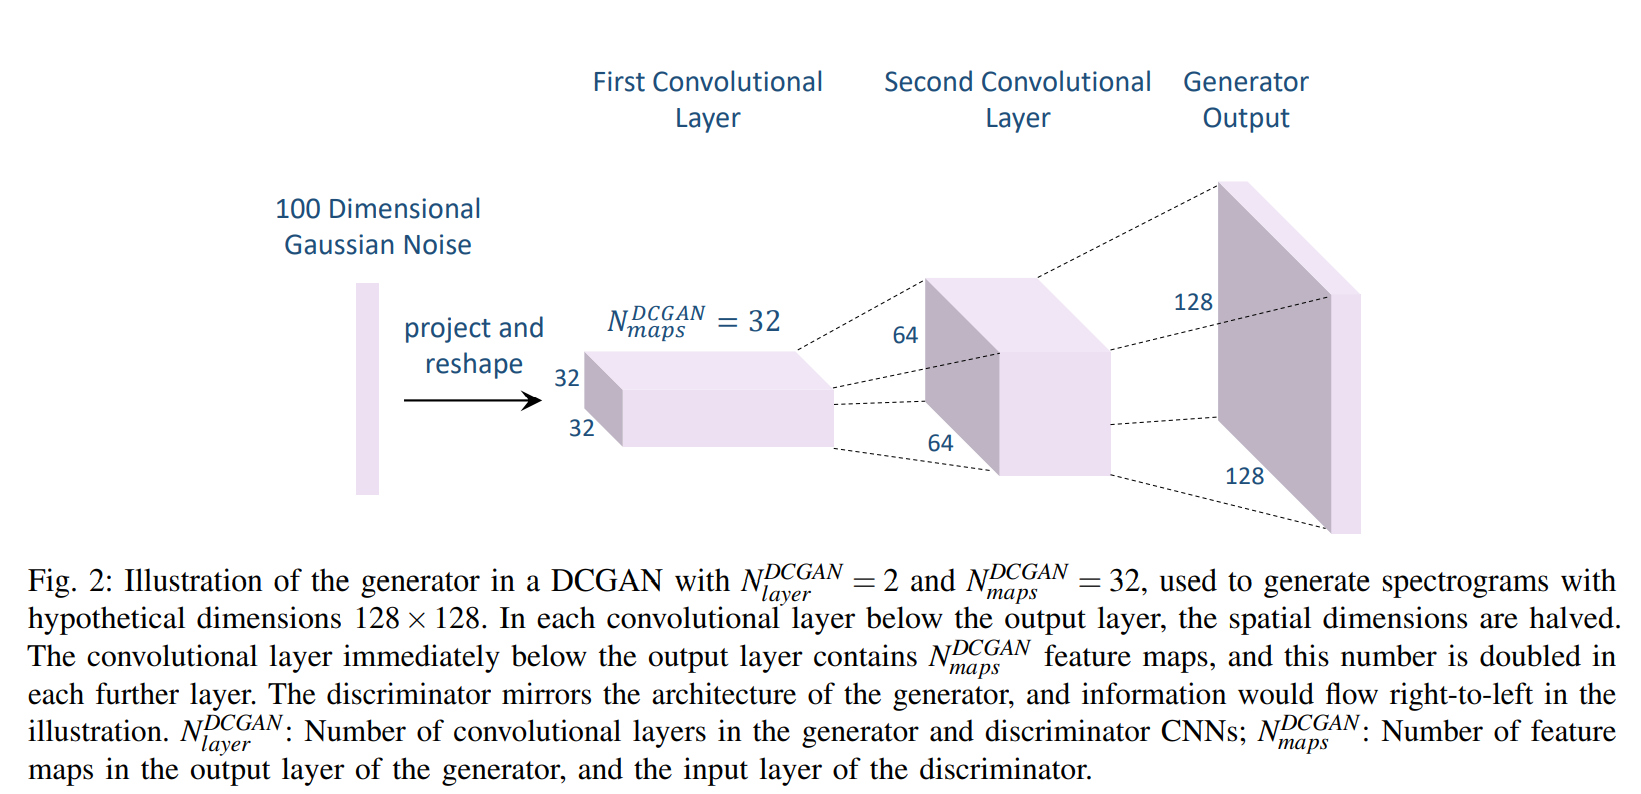( https://sci-hub.se/10.23919/EUSIPCO.2018.8553225)

In [5]:
def make_generator_model():
    model = Sequential(name='Generator')
    model.add(Dense(32*32*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((32, 32, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.summary()
    return model


In [6]:
def make_discriminator_model():
    model = Sequential(name='Discriminator')
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model


# Parameter Model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 262144)         │    26,214,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 262144)         │     1,048,576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 1)    │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,289,344 (107.92 MB)

 Trainable params: 27,764,672 (105.91 MB)

 Non-trainable params: 524,672 (2.00 MB)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,665 (1.29 MB)

 Trainable params: 337,665 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
generator_optimizer = Adam(learning_rate=0.00001, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.00002, beta_1=0.5)

# Training setup

In [9]:
@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs, batch_size):
    gen_losses = []
    disc_losses = []
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())
        
        gen_losses.append(sum(gen_loss_list) / len(gen_loss_list))
        disc_losses.append(sum(disc_loss_list) / len(disc_loss_list))
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_losses[-1]}, Discriminator Loss: {disc_losses[-1]}')
    
    return gen_losses, disc_losses

# Training Model

In [10]:
epochs = 100
batch_size = 16
class_dir = '/dataset-skripsi/dataset_ver6/spectrogram2/binary/arterial'
train_dataset = create_single_class_dataset(class_dir, batch_size)
gen_losses, disc_losses = train(train_dataset, epochs, batch_size)

/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-08-20 07:57:47.368876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDiscriminator_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Generator Loss: 0.7169124186038971, Discriminator Loss: 1.2732553631067276
Epoch 2, Generator Loss: 0.7711777240037918, Discriminator Loss: 0.9957510456442833
Epoch 3, Generator Loss: 0.8409272953867912, Discriminator Loss: 0.7879354953765869
Epoch 4, Generator Loss: 0.9811447709798813, Discriminator Loss: 0.6088595986366272
Epoch 5, Generator Loss: 1.2044997662305832, Discriminator Loss: 0.4522913061082363
Epoch 6, Generator Loss: 1.4932509809732437, Discriminator Loss: 0.32689613476395607
Epoch 7, Generator Loss: 1.8025995790958405, Discriminator Loss: 0.23164730332791805
Epoch 8, Generator Loss: 2.06732976436615, Discriminator Loss: 0.17529059574007988
Epoch 9, Generator Loss: 2.3272050321102142, Discriminator Loss: 0.13335469644516706
Epoch 10, Generator Loss: 2.555802583694458, Discriminator Loss: 0.10606248490512371
Epoch 11, Generator Loss: 2.7673537135124207, Discriminator Loss: 0.0862709041684866
Epoch 12, Generator Loss: 2.945103019475937, Discriminator Loss: 0.07255

In [ ]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses During Training')
    plt.legend()
    plt.show()

plot_losses(gen_losses, disc_losses)

# Save Model

In [12]:
#Save GAN model
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [13]:
generator = tf.keras.models.load_model('generator.h5')
discriminator = tf.keras.models.load_model('discriminator.h5')

# Model Evaluation

In [14]:
def compute_ssim(real_images, generated_images):
    ssim_scores = []
    for real, gen in zip(real_images, generated_images):
        real_np = np.squeeze(real)
        gen_np = np.squeeze(gen)
        score = ssim(real_np, gen_np, data_range=real_np.max() - real_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

In [15]:
def compute_inception_score(generated_images, n_split=5, eps=1e-16):
    if isinstance(generated_images, np.ndarray):
        generated_images = tf.convert_to_tensor(generated_images)
    
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    generated_images_rgb = tf.image.grayscale_to_rgb(generated_images)
    
    generated_images_resized = tf.image.resize(generated_images_rgb, (299, 299))
    generated_images_preprocessed = preprocess_input(generated_images_resized)

    preds = inception_model.predict(generated_images_preprocessed)
    preds = np.clip(preds, eps, 1 - eps)

    scores = []
    n_part = len(generated_images) // n_split
    for i in range(n_split):
        part = preds[i * n_part: (i + 1) * n_part]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

In [16]:
def compute_fid(real_images, generated_images, eps=1e-6):
    if isinstance(real_images, np.ndarray):
        real_images = tf.convert_to_tensor(real_images)
    if isinstance(generated_images, np.ndarray):
        generated_images = tf.convert_to_tensor(generated_images)
    
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    real_images_rgb = tf.image.grayscale_to_rgb(real_images)
    generated_images_rgb = tf.image.grayscale_to_rgb(generated_images)
    
    real_images_resized = tf.image.resize(real_images_rgb, (299, 299))
    real_images_preprocessed = preprocess_input(real_images_resized)
    
    generated_images_resized = tf.image.resize(generated_images_rgb, (299, 299))
    generated_images_preprocessed = preprocess_input(generated_images_resized)

    act1 = inception_model.predict(real_images_preprocessed)
    act2 = inception_model.predict(generated_images_preprocessed)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1 @ sigma2)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [17]:
def compute_discriminator_score(discriminator, generated_images):
    preds = discriminator.predict(generated_images)
    preds = np.squeeze(preds)
    ds_score = np.mean(preds )
    
    return ds_score

In [ ]:
class_dir = '/dataset-skripsi/dataset_ver6/spectrogram2/binary/arterial'
train_dataset = create_single_class_dataset(class_dir)
shuffled_dataset = train_dataset.shuffle(buffer_size=1000)
real_images, _ = next(iter(shuffled_dataset))
latent_dim = 100  

num_images = real_images.shape[0]  # Generate the same number of images as in real_images
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

generated_images = generator.predict(random_latent_vectors)

ssim_score = compute_ssim(real_images, generated_images)

is_mean, is_std = compute_inception_score(generated_images)

fid_score = compute_fid(real_images, generated_images)

ds_score = compute_discriminator_score(discriminator, generated_images)

print(f"SSIM Score: {ssim_score:.4f}")
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")
print(f"FID Score: {fid_score:.4f}")
print(f"Discriminator Score: {ds_score:.4f}")